In [25]:
# Initial imports
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nltk as nltk
from wordcloud import WordCloud
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient
load_dotenv()
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bfode\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
# Read your api key environment variable
# YOUR CODE HERE!
api_key = os.getenv("news_api")

In [27]:
# Create a newsapi client
# YOUR CODE HERE!
newsapi = NewsApiClient(api_key=api_key)

In [28]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key
newsapi = NewsApiClient(api_key=os.environ["news_api"])

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [29]:
# Get last 30days' worth of historical data for GS 
#Wells Fargo Co. (WFC), Goldman Sachs Group Inc. (GS), and Morgan Stanley (MS).

# Set the ticker
ticker = "GS"

# Set timeframe to '1D'
timeframe = "1D"

# Set current date and the date from one month ago using the ISO format
current_date = pd.Timestamp(datetime.now(), tz="America/New_York").isoformat()
past_date = pd.Timestamp(datetime.now()- timedelta(30), tz="America/New_York").isoformat()

# Get 4 weeks worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=past_date,
    end=current_date,
    after=None,
    until=None,
).df

# Display data
df.head()

GS                                    
                             open      high      low   close   volume
2021-06-07 00:00:00-04:00  392.89  393.2603  387.550  388.09  1815955
2021-06-08 00:00:00-04:00  385.79  386.4799  382.220  384.80  1946972
2021-06-09 00:00:00-04:00  383.44  384.2700  378.880  382.78  1817307
2021-06-10 00:00:00-04:00  389.08  389.6400  372.345  373.75  3301165
2021-06-11 00:00:00-04:00  375.47  378.7500  375.110  378.10  1693470

In [30]:
#Saving Raw data to Raw Data Folder

In [31]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df = df.drop(columns=["open", "high", "low", "volume"])

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

# Display sample data
df.head()

,close
2021-06-07,388.09
2021-06-08,384.80
2021-06-09,382.78
2021-06-10,373.75
2021-06-11,378.10


In [32]:
df_returns = df.pct_change().dropna()
df_returns.head()

,close
2021-06-08,-0.008477
2021-06-09,-0.005249
2021-06-10,-0.023591
2021-06-11,0.011639
2021-06-14,-0.013303


In [33]:
# Use newsapi client to get most relevant 20 headlines per day in the past month
def get_headlines(keyword):
    all_headlines = []
    all_dates = []    
    date = datetime.strptime(current_date[:10], "%Y-%m-%d")
    end_date = datetime.strptime(past_date[:10], "%Y-%m-%d")
    print(f"Fetching news about '{keyword}'")
    print("*" * 30)
    while date > end_date:
        print(f"retrieving news from: {date}")
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date)[:10],
            to=str(date)[:10],
            language="en",
            sort_by="relevancy",
            page=1,
        )
        headlines = []
        for i in range(0, len(articles["articles"])):
            headlines.append(articles["articles"][i]["title"])
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    return all_headlines, all_dates

In [34]:
goldman_headlines, dates = get_headlines("Goldman Sachs Group Inc.")

Fetching news about 'Goldman Sachs Group Inc.'
******************************
retrieving news from: 2021-07-06 00:00:00
retrieving news from: 2021-07-05 00:00:00
retrieving news from: 2021-07-04 00:00:00
retrieving news from: 2021-07-03 00:00:00
retrieving news from: 2021-07-02 00:00:00
retrieving news from: 2021-07-01 00:00:00
retrieving news from: 2021-06-30 00:00:00
retrieving news from: 2021-06-29 00:00:00
retrieving news from: 2021-06-28 00:00:00
retrieving news from: 2021-06-27 00:00:00
retrieving news from: 2021-06-26 00:00:00
retrieving news from: 2021-06-25 00:00:00
retrieving news from: 2021-06-24 00:00:00
retrieving news from: 2021-06-23 00:00:00
retrieving news from: 2021-06-22 00:00:00
retrieving news from: 2021-06-21 00:00:00
retrieving news from: 2021-06-20 00:00:00
retrieving news from: 2021-06-19 00:00:00
retrieving news from: 2021-06-18 00:00:00
retrieving news from: 2021-06-17 00:00:00
retrieving news from: 2021-06-16 00:00:00
retrieving news from: 2021-06-15 00:00:0

In [37]:
get_headlines("Goldman Sachs Group Inc.") =  pd.DataFrame(goldman_headlines)
goldman_headlines.to_csv('../../data/Rawdata/goldman_headlines.csv')

SyntaxError: cannot assign to function call (<ipython-input-37-887b888b1f14>, line 1)

In [38]:
# Instantiate SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [39]:
# Create function that computes average compound sentiment of headlines for each day
def headline_sentiment_summarizer_avg(headlines):
    sentiment = []
    for day in headlines:
        day_score = []
        for h in day:
            if h == None:
                continue
            else:
                day_score.append(sid.polarity_scores(h)["compound"])
        sentiment.append(sum(day_score) / len(day_score))
    return sentiment

In [40]:
# Get averages of each topics sentiment
goldman_avg = headline_sentiment_summarizer_avg(goldman_headlines)


In [41]:
# Combine Sentiment Averages into DataFrame
topic_sentiments = pd.DataFrame(
    {
        "goldman_avg": goldman_avg
    }
)

In [42]:
# Set the index value of the sentiment averages DataFrame to be the series of dates.
topic_sentiments.index = pd.to_datetime(dates)

In [43]:
# Merge with goldman returns
topic_sentiments = df_returns.join(topic_sentiments).dropna(how="any")

# Display data
display(topic_sentiments)

,close,goldman_avg
2021-06-08,-0.008477,0.130225
2021-06-09,-0.005249,0.036050
2021-06-10,-0.023591,0.135205
2021-06-11,0.011639,0.081830
2021-06-14,-0.013303,0.014035
2021-06-15,-0.003940,0.159560
2021-06-16,-0.001426,0.084235
2021-06-17,-0.025790,0.102160
2021-06-18,-0.035159,0.169720
2021-06-21,0.025488,0.342390


In [44]:
topic_sentiments.corr().style.background_gradient()

,close,goldman_avg
close,1.000000,0.194798
goldman_avg,0.194798,1.000000


In [45]:
## Build and Train the LSTM RNN

In [46]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [47]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 1 is the 'Goldman Average' column
# Column index 0 is the `Close` column
feature_column = 1
target_column = 0
X, y = window_data(topic_sentiments, window_size, feature_column, target_column)

In [48]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [49]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [50]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [52]:
#Build the LSTM model. 
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [53]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [54]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [55]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)


Epoch 1/10
6/6 [==============================] - 7s 8ms/step - loss: 0.3246
Epoch 2/10
6/6 [==============================] - 0s 8ms/step - loss: 0.1901
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 0.1033
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0798
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0512
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0784
Epoch 7/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0610
Epoch 8/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0575
Epoch 9/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0622
Epoch 10/10
6/6 [==============================] - 0s 8ms/step - loss: 0.0478


In [56]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.2052


0.20519308745861053

In [57]:
predicted = model.predict(X_test)

In [58]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [59]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2021-07-01,0.018316,0.008540
2021-07-02,-0.011820,0.008889
2021-07-06,-0.002134,0.009572


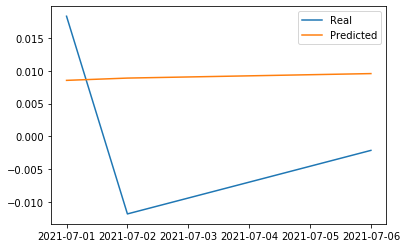

In [60]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
stocks.plot()

In [ ]:
Balanced Random Forest Classifier

In [317]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [319]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)

In [328]:
data_scaler = StandardScaler()

In [329]:
X_scaler = data_scaler.fit(X_train)

In [330]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# Transforming y_moons to a vertical vector
y_moons = y_moons.reshape(-1, 1)

NameError: name 'y_moons' is not defined

In [ ]:
# Creating a DataFrame to plot the non-linear dummy data
df_moons = pd.DataFrame(X_moons, columns=["Feature 1", "Feature 2"])
df_moons["Target"] = y_moons
df_moons.head()